In [1]:
import neo
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram
from scipy.signal import welch
from scipy.signal import butter, filtfilt


In [2]:
# Low-pass filter function
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    return filtfilt(b, a, data, axis=0)  # Use filtfilt to apply filter

In [3]:
# List of filenames for each eye
filenames = [
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 1/10Hz_1V_neg500mV_1ms003.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 2/10Hz_1V_neg500mV_1ms002.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 3/10Hz_1V_neg500mV_1ms004.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 4/10Hz_1V_neg500mV_1ms018.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 5/10Hz_1V_neg500mV_1ms004.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 6/10Hz_1V_neg500mV_1ms011.ns5"
]

# Initialize an empty list to hold the data from all eyes
all_data = []
filtered_data = []

# Parameters for the low-pass filter
fs = 30000  # Sampling frequency (Hz)
cutoff_frequency = 50  # Cutoff frequency for the low-pass filter (Hz)

# Loop through each file and read the data
for filename in filenames:
    print(f"Reading data from file: {filename}")
    reader = neo.io.BlackrockIO(filename=filename)
    
    # Read the data from the file
    block_SA = reader.read_block()
    
    # Access the first segment
    segment_SA = block_SA.segments[0]
    
    # Access the first analog signal within this segment
    analog_signal_SA = segment_SA.analogsignals[0]
    
    # Access the signal data as a NumPy array and append it to the list
    data_SA = np.asarray(analog_signal_SA.magnitude)
    all_data.append(data_SA)

    # Apply the low-pass filter to each channel's data and store the filtered version
    # filtered_signals = [apply_lowpass_filter(channel_data, cutoff_frequency, fs) for channel_data in data_SA]
    # filtered_data.append(filtered_signals)

all_data = np.array(all_data)
# Print shape of the dataS
print(f"Data shape: {np.shape(all_data)}")
# print(f"Filtered data shape (for one eye): {np.shape(filtered_data)}")


Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 1/10Hz_1V_neg500mV_1ms003.ns5
Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 2/10Hz_1V_neg500mV_1ms002.ns5
Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 3/10Hz_1V_neg500mV_1ms004.ns5
Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 4/10Hz_1V_neg500mV_1ms018.ns5
Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 5/10Hz_1V_neg500mV_1ms004.ns5
Reading data from file: /Users/marielunde/Desktop/Thesis/all data/3D/Eye 6/10Hz_1V_neg500mV_1ms011.ns5
Data shape: (6, 300300, 32)


In [55]:
# average_per_eye = np.mean(all_data, axis=2)

average_per_eye = np.mean(all_data, axis=2)

# Check the shape of the resulting array
print(f"Shape of averaged data: {average_per_eye.shape}")  # Should be (num_eyes, num_samples)

Shape of averaged data: (6, 300300)


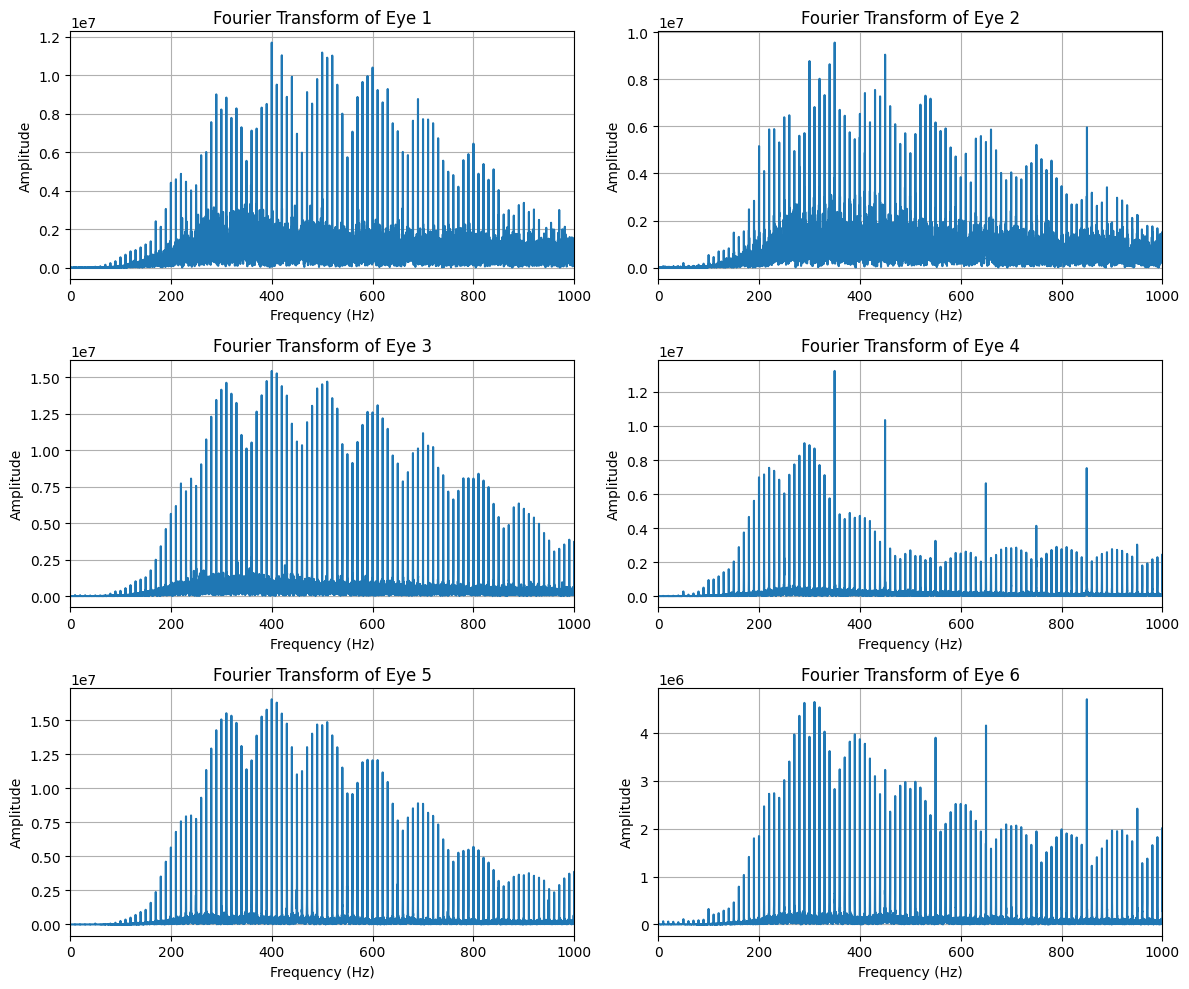

Fourier data shape: (6, 2, 300300)


In [56]:
sampling_rate = 30000  # Hz
fourier_data = []
power_spectra = []

# Set up a 3x2 grid for plotting
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.ravel()  # Flatten the 2D array of axes to iterate over

# Define the frequency range you want to zoom into
zoom_min_freq = 0  # Minimum frequency to display (in Hz)
zoom_max_freq = 1000  # Maximum frequency to display (in Hz)

# Loop through each eye's data (assuming all_data is a list)
for i in range(len(all_data)):  # Use len() instead of shape
    # Choose a specific channel (for example, channel 0)
    data_eye = average_per_eye[i]

    # Apply Fourier Transform on the data
    N = len(data_eye)  # Number of samples in the data
    yf = fft(data_eye)  # Perform FFT
    xf = fftfreq(N, 1 / sampling_rate)  # Frequency axis

    # Save Fourier transform data
    fourier_data.append((xf, yf))  # Store both frequency and transformed data

    # Compute Power Spectrum (squared magnitude of Fourier coefficients)
    power_spectrum = np.abs(yf[:N // 2]) ** 2
    power_spectra.append(power_spectrum)

    # Plot the Fourier Transform on the 3x2 grid
    axes[i].plot(xf[:N // 2], np.abs(yf[:N // 2]))  # Plot positive frequencies only
    axes[i].set_title(f"Fourier Transform of Eye {i + 1}")
    axes[i].set_xlabel("Frequency (Hz)")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid(True)

    # Zoom in by setting x-axis limits to focus on the desired frequency range
    axes[i].set_xlim([zoom_min_freq, zoom_max_freq])

# Adjust layout for clarity and save the figure
plt.tight_layout()
plt.show()

# Print shape of the Fourier transform data
print(f"Fourier data shape: {np.shape(fourier_data)}")


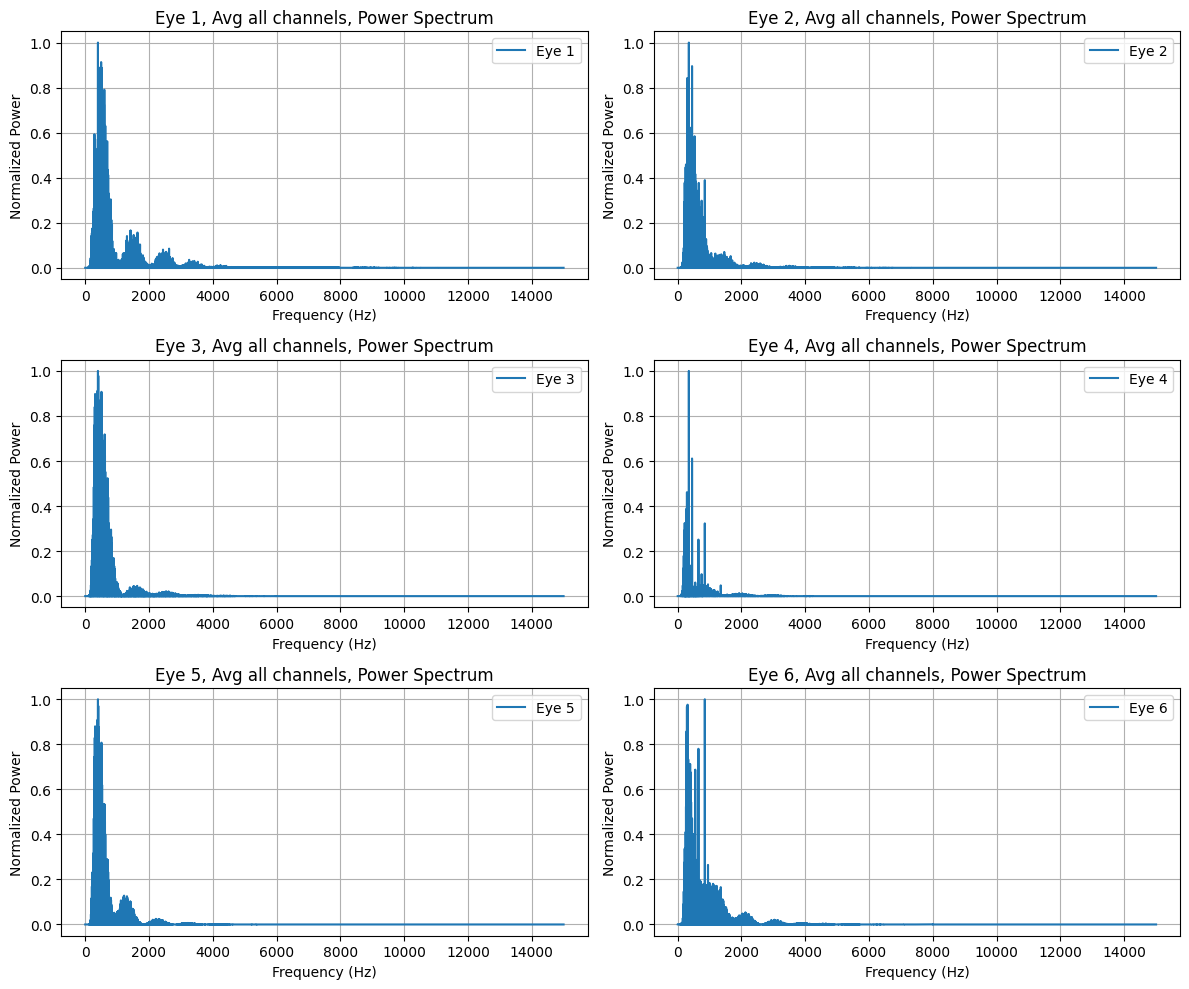

In [57]:
# Convert power spectra to NumPy array for easier manipulation
power_spectra = np.array(power_spectra)

# Normalize the power spectra for comparison (optional)
normalized_power_spectra = power_spectra / np.max(power_spectra, axis=1, keepdims=True)

# Plot all normalized power spectra to visually compare across eyes
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.ravel()  

for i in range(len(filenames)):
    axes[i].plot(xf[:N // 2], normalized_power_spectra[i], label=f'Eye {i+1}')
    axes[i].set_title(f'Eye {i+1}, Avg all channels, Power Spectrum')
    axes[i].set_xlabel("Frequency (Hz)")
    axes[i].set_ylabel("Normalized Power")
    axes[i].legend(loc="upper right")
    axes[i].grid(True)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

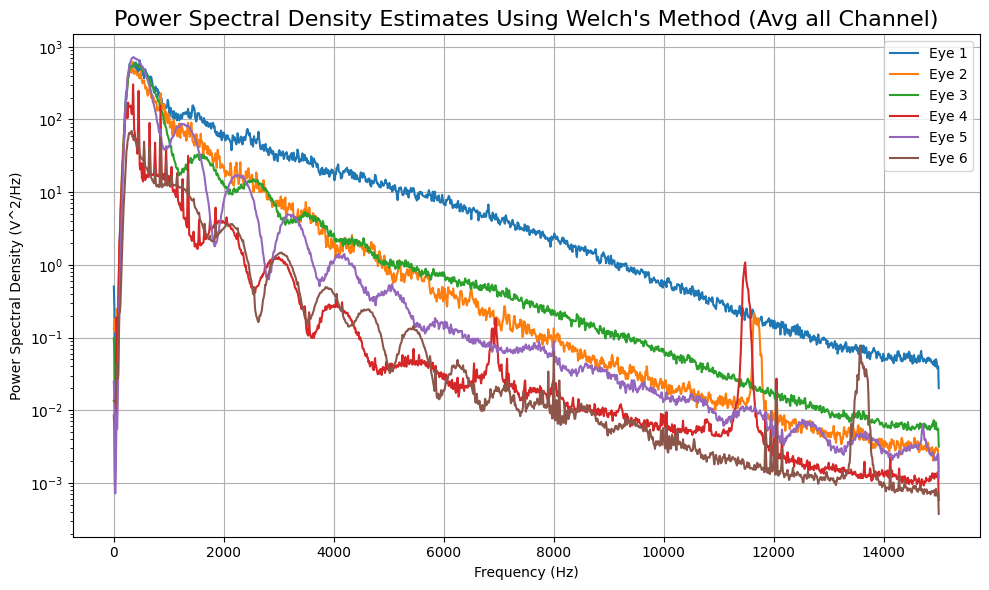

In [58]:
# Parameters for Welch's method
fs = 30000  # Sampling frequency (Hz)
nperseg = 3000  # Length of each segment
noverlap = nperseg // 2  # Overlap between segments

# Initialize an array to hold the power spectral density for a specific channel
psd_results = []

# Specify the channel to analyze (e.g., channel 0)
channel_index = 0

# Apply Welch's method to the specified channel's data across all eyes
for eye_data in average_per_eye:
    # Extract the data for the specified channel
    # single_channel_data = eye_data[:, channel_index]  # Shape (300300,) for the selected channel
    f, Pxx = welch(eye_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    psd_results.append((f, Pxx))

# Plot the results in a single plot
plt.figure(figsize=(10, 6))
for i, (f, Pxx) in enumerate(psd_results):
    plt.semilogy(f, Pxx, label=f'Eye {i + 1}')  # Use a logarithmic scale for better visualization

plt.title('Power Spectral Density Estimates Using Welch\'s Method (Avg all Channel)', fontsize=16)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V^2/Hz)')
plt.grid(True)
plt.legend(loc='upper right')

# Adjust layout for clarity
plt.tight_layout()
plt.show()


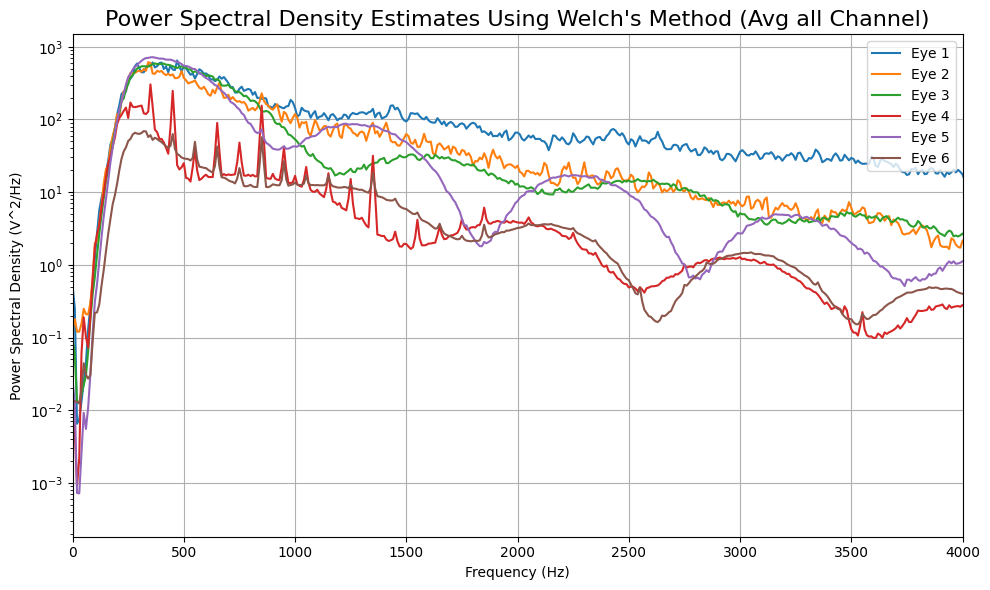

In [61]:
# Parameters for Welch's method
fs = 30000  # Sampling frequency (Hz)
nperseg = 3000  # Length of each segment
noverlap = nperseg // 2  # Overlap between segments

# Initialize an array to hold the power spectral density for a specific channel
psd_results = []

# Specify the channel to analyze (e.g., channel 0)
channel_index = 0

# Apply Welch's method to the specified channel's data across all eyes
for eye_data in average_per_eye:
    # Extract the data for the specified channel
    f, Pxx = welch(eye_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    psd_results.append((f, Pxx))

# Plot the results in a single plot
plt.figure(figsize=(10, 6))
for i, (f, Pxx) in enumerate(psd_results):
    plt.semilogy(f, Pxx, label=f'Eye {i + 1}')  # Use a logarithmic scale for better visualization

plt.title('Power Spectral Density Estimates Using Welch\'s Method (Avg all Channel)', fontsize=16)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V^2/Hz)')
plt.xlim(0, 4000)  # Zoom in on the first 2000 Hz
plt.grid(True)
plt.legend(loc='upper right')

# Adjust layout for clarity
plt.tight_layout()
plt.show()


## Spectrogram

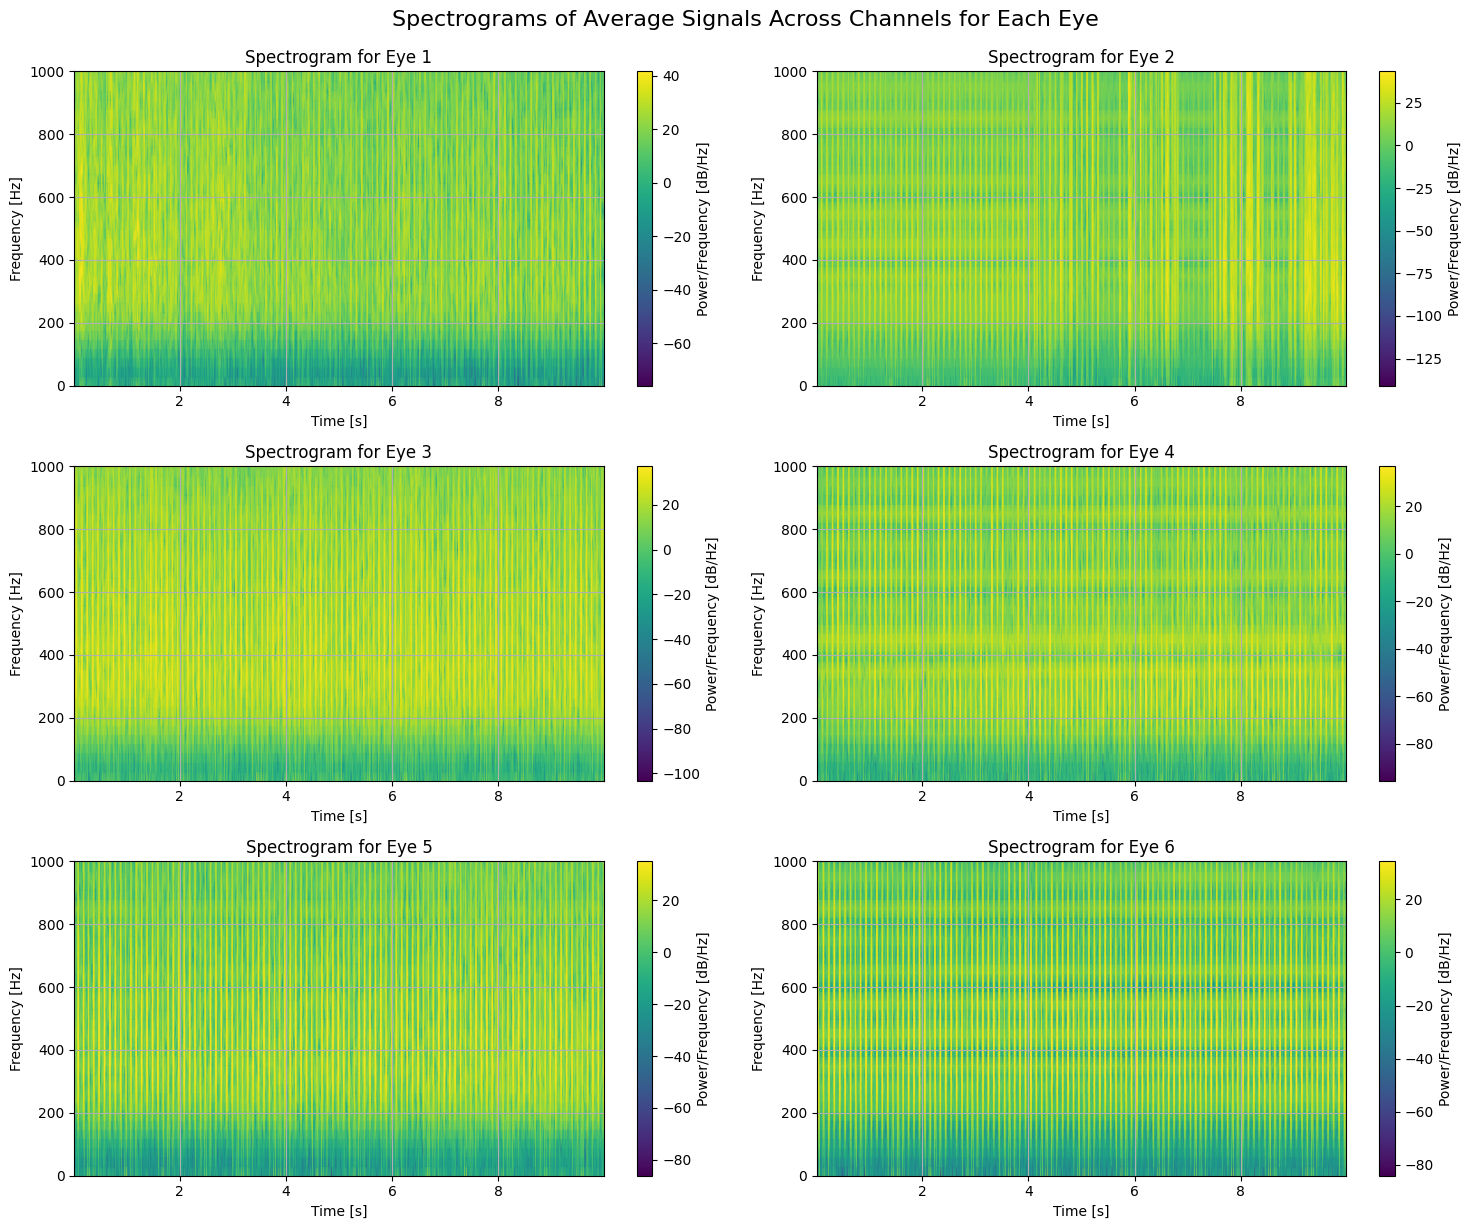

In [59]:
# Plotting the Spectrograms for all eyes
plt.figure(figsize=(15, 12))
for i in range(len(all_data)):
    # Calculate the spectrogram
    single_channel_data = all_data[i][:, 0]  # Shape (300300,) for the selected channel

    # f, t, Sxx = spectrogram(average_per_eye[i], fs=30000, nperseg=1024, noverlap=512)
    f, t, Sxx = spectrogram(single_channel_data, fs=30000, nperseg=1024, noverlap=512)
    
    plt.subplot(3, 2, i + 1)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.title(f'Spectrogram for Eye {i + 1}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.colorbar(label='Power/Frequency [dB/Hz]')
    plt.ylim(0, 1000)  # Adjust the frequency axis limits as needed
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Spectrograms of Average Signals Across Channels for Each Eye', fontsize=16, y=1.02)
plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import neo
from mpl_toolkits.mplot3d import Axes3D

# List of filenames for each eye
filenames = [
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 1/10Hz_1V_neg500mV_1ms003.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 2/10Hz_1V_neg500mV_1ms002.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 3/10Hz_1V_neg500mV_1ms004.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 4/10Hz_1V_neg500mV_1ms018.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 5/10Hz_1V_neg500mV_1ms004.ns5",
    "/Users/marielunde/Desktop/Thesis/all data/3D/Eye 6/10Hz_1V_neg500mV_1ms011.ns5"
]

# Initialize an empty list to hold the data for each eye
all_data = []

# Loop through each file and read the data
for filename in filenames:
    reader = neo.io.BlackrockIO(filename=filename)
    
    # Read the data from the file
    block_SA = reader.read_block()
    
    # Access the first segment
    segment_SA = block_SA.segments[0]
    
    # Access all analog signals within this segment
    signals = [np.asarray(segment_SA.analogsignals[i].magnitude) for i in range(len(segment_SA.analogsignals))]
    
    # Store the signals for later use
    all_data.append(signals)

# Define parameters for the spectrogram
fs = 30000  # Sampling frequency (Hz)

# Plotting the 3D Spectrograms for all eyes
fig = plt.figure(figsize=(15, 12))
for i in range(len(all_data)):
    # Average over channels for the current eye
    average_signal = np.mean([i], axis=0)
    
    # Calculate the spectrogram
    f, t, Sxx = spectrogram(average_signal, fs=fs, nperseg=1024, noverlap=512)
    
    # Create a 3D subplot
    ax = fig.add_subplot(3, 2, i + 1, projection='3d')
    
    # Prepare data for the 3D plot
    X, Y = np.meshgrid(t, f)
    Z = 10 * np.log10(Sxx)  # Convert to dB scale

    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    
    # Set titles and labels
    ax.set_title(f'3D Spectrogram for Eye {i + 1}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_zlabel('Power/Frequency [dB/Hz]')
    ax.set_ylim(0, 1000)  # Adjust the frequency limits as needed

plt.tight_layout()
plt.suptitle('3D Spectrograms of Average Signals Across Channels for Each Eye', fontsize=16, y=1.02)
plt.show()


AttributeError: 'list' object has no attribute 'T'

<Figure size 1500x1200 with 0 Axes>

## Toy data

In [21]:
# do low pass filter
from scipy.signal import butter, lfilter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# high pass filter
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# band stop filter
def butter_bandstop(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyquist, cutoff[1] / nyquist]
    b, a = butter(order, normal_cutoff, btype='bandstop', analog=False)
    return b, a

def butter_bandstop_filter(data, cutoff, fs, order=5):
    b, a = butter_bandstop(cutoff, fs, order=order)
    y = lfilter(b, a, data) # filtfilt doesn't work with this
    return y


In [22]:
# generate smooth sine wave with sampling frequency 30 kHz for 0.01 second
fs = 30000
f = 10
f2 = 100

t = np.linspace(0, 1, fs)
x = np.sin(2 * np.pi * f * t)
y = np.sin(2 * np.pi * f2 * t)
x = x+y



# do low pass filter
filtered = butter_highpass_filter(x, 50, fs, 5)


In [23]:
filtered.shape

(30000,)

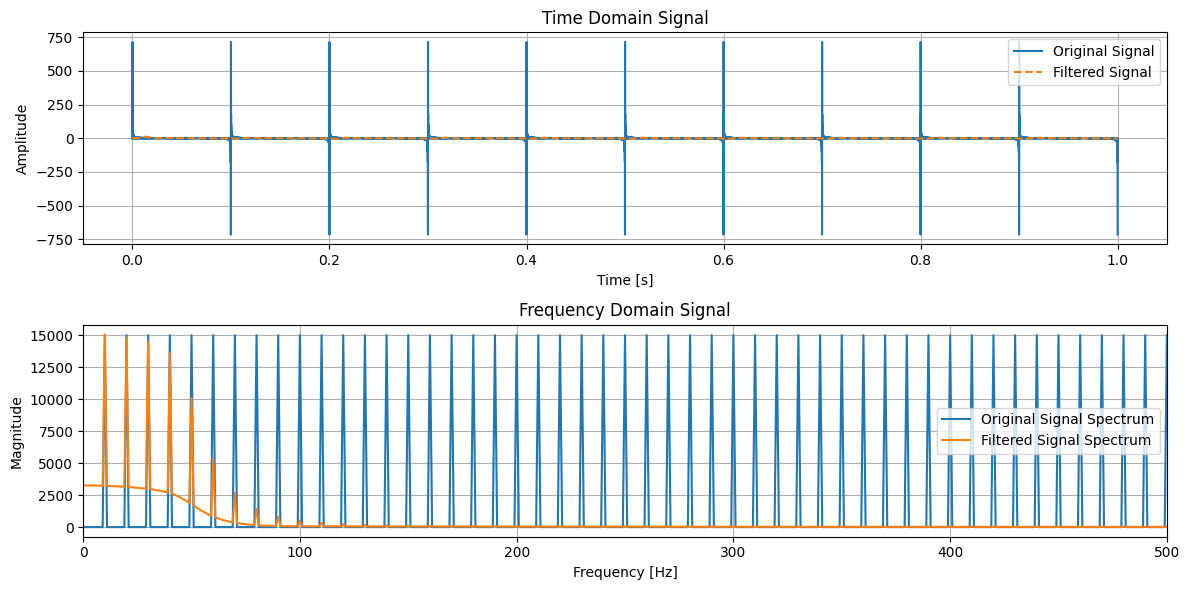

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from scipy.fft import fft, fftfreq

# Function to create a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply the low-pass filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Generate smooth sine wave
fs = 30000  # Sampling frequency
freqs = np.arange(10, 10000, 10)

# Time vector for 1 second
t = np.linspace(0, 1, fs, endpoint=False)

# Create the signal
#x = np.sin(2 * np.pi * f * t) + np.sin(2 * np.pi * f2 * t) + np.sin(2 * np.pi * f3 * t) + np.sin(2 * np.pi * f4 * t) + np.sin(2 * np.pi * f5 * t)
x = np.sin(2 * np.pi * freqs[0]*t)
for i in range(1, len(freqs)):
    x += np.sin(2 * np.pi * freqs[i]*t)
    
# Apply low-pass filter
cutoff = 50  # Cutoff frequency for the low-pass filter
filtered = butter_lowpass_filter(x, cutoff, fs, order=5)

# Perform Fourier Transform
N = len(x)
yf_original = fft(x)
yf_filtered = fft(filtered)

# Frequency axis
xf = fftfreq(N, 1/fs)

# Plot the original and filtered signals in the time domain
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, x, label='Original Signal')
plt.plot(t, filtered, label='Filtered Signal', linestyle='--')
plt.title('Time Domain Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Plot the frequency spectrum
plt.subplot(2, 1, 2)
plt.plot(xf[:N//2], np.abs(yf_original[:N//2]), label='Original Signal Spectrum')
plt.plot(xf[:N//2], np.abs(yf_filtered[:N//2]), label='Filtered Signal Spectrum')
plt.title('Frequency Domain Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0, 500)  # Limit x-axis for better visualization
plt.legend()
plt.grid()

# Adjust layout for clarity
plt.tight_layout()
plt.show()
